In [ ]:
!pip install datasets
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import math
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
my_dataset = load_dataset("sms_spam")

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

Dataset sms_spam downloaded and prepared to /root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset = my_dataset["train"]


Total size of dataset:  5574
Number of non-spam SMS:  4827
Number of spam SMS:  747
Maximum number of words in a sentence:  171


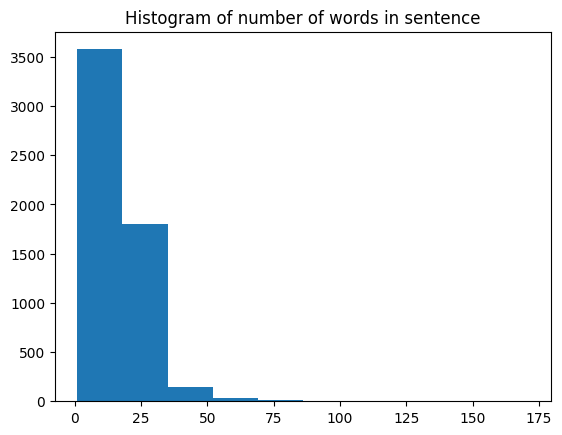

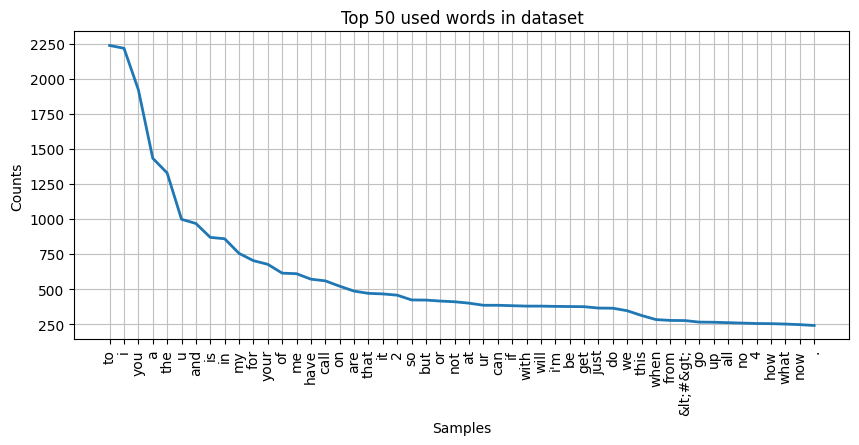

In [ ]:
# EDA step (Khai phá dữ liệu)
# Size of each class
print("Total size of dataset: ", dataset.num_rows)
print("Number of non-spam SMS: ",len([i for i in dataset["label"] if i == 0]))
print("Number of spam SMS: ",len([i for i in dataset["label"] if i == 1]))

# Explore length of sentences
num_of_words = [len(sentence.split()) for sentence in dataset["sms"]]
print("Maximum number of words in a sentence: ",max(num_of_words))
plt.hist(num_of_words)
plt.title("Histogram of number of words in sentence")
plt.show()

# Explore most use word in dataset
most_used_words = nltk.FreqDist(word for sentence in dataset["sms"] for word in sentence.lower().split())
plt.subplots(figsize=(10,4))
top_used = 50
plt.title("Top "+str(top_used)+" used words in dataset")
most_used_words.plot(top_used)
plt.show()

In [ ]:
#Download resource for nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Cleaning data
#cleaned_data = [re.sub(r'http\S+', '',sentence) for sentence in dataset["sms"]]

# Remove any characters accept alphabet characters and numbers
cleaned_data = [re.sub("[^a-zA-Z0-9]"," ",sentence) for sentence in dataset["sms"]]
# Remove unnescessary space
cleaned_data = [" ".join(sentence.split()) for sentence in cleaned_data]
# Convert all upper character to lower case
cleaned_data = [sentence.lower() for sentence in cleaned_data]
# Remove stop words
swords = stopwords.words("english")

final_cleaned_data = []
for sentence in cleaned_data:
    new_stnc = [word for word in sentence.split() if word not in swords]
    final_cleaned_data.append(" ".join(new_stnc))

In [ ]:
# Data trước khi cleaning
dataset["sms"][0:15]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n',
 'Ok lar... Joking wif u oni...\n',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n",
 'U dun say so early hor... U c already then say...\n',
 "Nah I don't think he goes to usf, he lives around here though\n",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv\n",
 'Even my brother is not like to speak with me. They treat me like aids patent.\n',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune\n",
 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours o

In [ ]:
# Data sau khi cleaning
final_cleaned_data[0:15]

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry question std txt rate c apply 08452810075over18',
 'u dun say early hor u c already say',
 'nah think goes usf lives around though',
 'freemsg hey darling 3 week word back like fun still tb ok xxx std chgs send 1 50 rcv',
 'even brother like speak treat like aids patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune callers press 9 copy friends callertune',
 'winner valued network customer selected receivea 900 prize reward claim call 09061701461 claim code kl341 valid 12 hours',
 'mobile 11 months u r entitled update latest colour mobiles camera free call mobile update co free 08002986030',
 'gonna home soon want talk stuff anymore tonight k cried enough today',
 'six chances win cash 100 20 000 pounds txt csh11 send 87575 cost 150p day 6days 16 tsandcs 

In [ ]:
# Tokenizing data (Convert dữ liệu text sang ma trận số)
vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
X_converted = vectorizer.fit_transform(final_cleaned_data)


In [ ]:
# Split dataset into train set and validation set, shuffle before split
val_train_ratio = 0.3
X_train, X_val, Y_train, Y_val = train_test_split(X_converted, dataset["label"], test_size = val_train_ratio, random_state = 400,shuffle = True)

In [ ]:
# Imbalance class in training set
print("Size of class 0 (non-spam) in traing set: ",len([i for i in Y_train if i == 0]))
print("Size of class 1 (spam) in traing set: ",len([i for i in Y_train if i == 1]))

Size of class 0 (non-spam) in traing set:  3386
Size of class 1 (spam) in traing set:  515


In [ ]:
#Use SMOTE method imbalance class processing for only training set
oversample = SMOTE(sampling_strategy = "minority", random_state = 300, k_neighbors = 20)
X_train_new, Y_train_new = oversample.fit_resample(X_train, Y_train)

In [ ]:
# Imbalance class in training set after over-sampling
print("Size of class 0 (non-spam) in traing set: ",len([i for i in Y_train_new if i == 0]))
print("Size of class 1 (spam) in traing set: ",len([i for i in Y_train_new if i == 1]))

Size of class 0 (non-spam) in traing set:  3386
Size of class 1 (spam) in traing set:  3386


In [ ]:
model_clf = MultinomialNB(alpha = 0.3)
# Training model
model_clf.fit(X_train_new, Y_train_new)
# Predict on Test test
y_pred = model_clf.predict(X_val)
# Get probability output
y_score = model_clf.predict_proba(X_val)[:,1]

# Print out result
print("Model 1")
print("Accuracy: ",accuracy_score(Y_val, y_pred))
print("Confusion matrix: \n", confusion_matrix(Y_val, y_pred))

Model 1
Accuracy:  0.968320382546324
Confusion matrix: 
 [[1404   37]
 [  16  216]]


In [ ]:
model = SVC(kernel = 'rbf', probability=True)
# training model
model.fit(X_train_new,Y_train_new)
# Predict on validation test
y_pred_SVC = model.predict(X_val)
# Get probability output
y_score_SVC = model.predict_proba(X_val)[:,1]
# Print out result
print("Model 2")
print("Accuracy: ",accuracy_score(Y_val, y_pred_SVC))
print("Confusion matrix: \n", confusion_matrix(Y_val, y_pred_SVC))

Model 2
Accuracy:  0.8702928870292888
Confusion matrix: 
 [[1337  104]
 [ 113  119]]


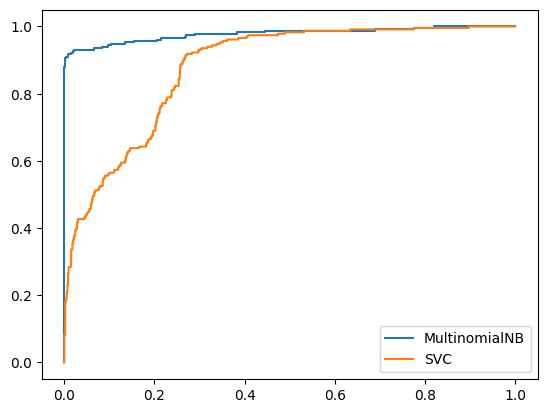

In [ ]:
def plot_roc_curve(predict_list, Y_true, method_list):
    for y_pred, method in zip(predict_list,method_list):
        fpr, tpr, _ = roc_curve(Y_val, y_pred)
        plt.plot(fpr,tpr,label = method)
        plt.legend()

plot_roc_curve([y_score, y_score_SVC], Y_val,["MultinomialNB","SVC"])

In [ ]:
# Chuẩn bị dữ liệu
# Đọc dữ liệu từ file
with open('data.txt', 'r') as f:
    data = f.readlines()

# Tách dữ liệu thành các tin nhắn và nhãn tương ứng
messages = []
labels = []
for line in data:
    message = line.strip().split('   ')[0]
    label = line.strip().split('   ')[1]
    messages.append(message)
    labels.append(int(label))

# Trích xuất đặc trưng
# Sử dụng CountVectorizer để chuyển đổi các tin nhắn thành ma trận đặc trưng
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(messages)

# Xây dựng mô hình SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X, labels)

# Nhập tin nhắn cần phân loại
new_message = input("Nhập tin nhắn cần phân loại: ")

# Chuyển đổi tin nhắn thành ma trận đặc trưng
new_X = vectorizer.transform([new_message])

# Sử dụng mô hình SVM để phân loại tin nhắn
result = svm_model.predict(new_X)

# In kết quả phân loại
if result[0] == 0:
    print("Tin nhắn này không phải là spam.")
else:
    print("Tin nhắn này là spam.")

Nhập tin nhắn cần phân loại: hello how are you today
Tin nhắn này là spam.


In [ ]:
data[4].strip().split('   ')

['You have been selected for a special offer. Click here to claim your prize.',
 ' 1']